# Práctica 4. Predicción de pasajeros de avión con series temporales

En esta práctica exploraremos diferentes técnicas para el estudio de series temporales. Utilizaremos el conocido conjunto de datos de pasajeros de avión, que contiene los pasajeros mensuales de una aerolínea internacional. El objetivo del ejercicio es ser capaces de predecir los pasajeros que habrá un determinado mes a partir de los datos de los meses anteriores: es un claro ejemplo de un problema de series temporales. Planteremos el problema para resolverlo tanto con métodos clásicos (*SARIMA*) como con métodos basados en redes neuronales recurrentes.

## Importación de las librerías

A las librerías usuales que venimos utilizando en otras prácticas (`numpy`, `matplotlib`, `tensorflow` y `sklearn`) añadiremos `pandas` y `seaborn`. La primera la utilizaremos para la carga de los datos, y la segunda para realizar algunas representaciones gráficas que nos ayudarán entender mejor el problema.

In [80]:
import math

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from attention import Attention

In [81]:
## Este fragmento de código puede servir para solucionar algunos errores de CUDA
try:
    tf_gpus = tf.config.list_physical_devices('GPU')
    for gpu in tf_gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except:
    pass 

In [96]:
## Opciones generales de Matplotlib para ajustar las figuras
plt.rcParams['figure.figsize'] = [9, 4]
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

In [83]:
# Fijamos la semilla para mantener la reproducibilidad
np.random.seed(42)

## Carga de los datos

Los datos que vamos a utilizar están alojados en un repositorio de *GitHub* ([link](https://github.com/jbrownlee/Datasets)). Esto quiere decir que para poder utilizarlos tendremos dos posibilidades:

- Descargar el dataset y cargarlo con `pandas`.
- Cargarlo directamente con `pandas` sin tener que descargar nada manualmente.

Esta última opción es muy práctica por varios motivos: nos evita tener que descargar y almacenar los archivos manualmente, y permite que el código sea mucho más autocontenido, ya que si queremos que otra persona pueda ejecutar nuestro código no será necesario que compartamos el conjunto de datos. Para hacerlo solamente tendremos que introducir el enlace directo al archivo de datos en la función `pd.read_csv()`.

> Nota: Para obtener el enlace adecuado tendremos que clicar el botón *Raw* de GitHub que aparece al abrir el archivo.

Siempre que importemos un `dataframe` con `pandas` es buena idea visualizar las primeras columnas con el método `.head()`. También podemos utilizar `.describe()` e `.info()` para obtener información general de los datos.

In [84]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv')
print("El conjunto de datos tiene {} filas y {} columnas.".format(*df.shape))
df.head()

El conjunto de datos tiene 144 filas y 2 columnas.


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


### Exploración de los datos

Vemos que el conjunto de datos tiene solo dos columnas: la fecha y los pasajeros. Como cabe la posibilidad de que `pandas` no interprete correctamente el tipo de datos de cada columna, antes de empezar a trabajar es recomendable revisarlo con el método `.info()`:

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Esto permite ver que la columna `Month` no es de tipo fecha (`datetime`), si no un tipo `object` genérico que aparece cuando `pandas` no sabe interpretarlo. Los datos de tipo `datetime` tienen propiedades especialmente útiles, así que vamos a convertirlo utilizando la función `pd.to_datetime()`. Al utilizarla aparece también el día del mes, que como es desconocido se considera como el día 1.

In [86]:
df['Month'] = pd.to_datetime(df['Month'], format="%Y-%m")
df.head(1)

,Month,Passengers
0,1949-01-01,112


También vamos a renombrar la columna porque en realidad no representa un mes, representa una fecha. Para ello utilizamos el método `.rename()`:

In [87]:
df=df.rename(columns={'Month':'Date'})
df.head(1)

,Date,Passengers
0,1949-01-01,112


Ahora mismo, tal y como tenemos codificada la fecha no podemos utilizarla como una característica de nuestro modelo porque no es un número. Una aproximación usual es crear columnas nuevas que representen únicamente el día, el mes, el año, etc. Esto da pie a realizar una pequeña ingeniería de características y plantear cómo se tienen que tratar este tipo de datos.

Al haber transformado la columna `Date` a formato `datetime` podemos extraer de forma cómoda el mes y el año con los atributos `.month` y `.year`.

In [88]:
df["Month"] = df['Date'].apply(lambda x: x.month)
df["Year"] = df['Date'].apply(lambda x: x.year)
df.head()

,Date,Passengers,Month,Year
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949


El último cambio que podemos hacer es convertir la columna `Date` en el índice de nuestro `dataframe`. No es un cambio que sea realmente determinante, pero como vamos a hacer todas las representaciones en función de esta columna, puede hacernos el trabajo algo más fácil. Lo podemos hacer con el método `.set_index()`:

In [89]:
df = df.set_index('Date')
df.head(1)

,Passengers,Month,Year
Date,,,
1949-01-01,112,1,1949


### Visualización de los datos

Una vez hemos preparado los datos para el análisis es recomendable representarlos gráficamente para ver de forma sencilla cómo es la información con la que estamos trabajando. En un problema de series temporales nos interesa ver la evolución de las características (los pasajeros en este caso) con el tiempo. Esto da pie a realizar tres visualizaciones:

- Pasajeros en función del tiempo: Es la representación más básica. Representa nuestra variable respuesta frente a la variable independiente. Nos da información de la tendencia general de los datos.
- Pasajeros por año: Resume la evolución general de los pasajeros. Es una buena representación para estudiar la tendencia general cuando tenemos tantos datos que no podemos representarlos todos, pero puede enmascarar la dependencia con los meses y esconder los ciclos cortos.
- Pasajeros por mes: Otra forma de resumir la información que permite estudiar los ciclos cortos, pero enmascara la tendencia a largo plazo.

Siempre es buena idea utilizar tanto representaciones *directas* como representaciones resumen, ya que cada una nos permite ver cosas diferentes. Además, en conjuntos de datos muy grandes puede ser inviable representar todos los datos y tendremos que utilizar siempre representaciones resumen.

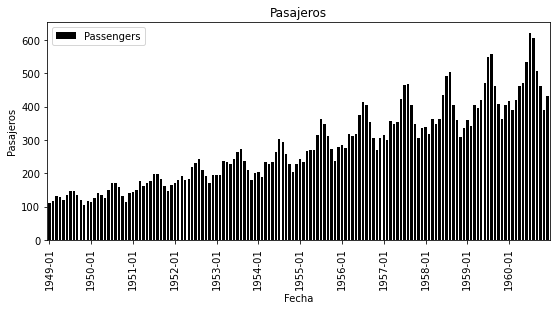

In [97]:
ax = df.plot(y='Passengers', kind='bar', 
             title = 'Pasajeros', color = 'black', 
             width = 0.7, linewidth = 0.5)
new_ticks = ax.get_xticklabels()[::12]
new_ticks_2 = [tick.set(text=tick.get_text()[:7]) for tick in new_ticks]
ax.set_xticks(np.arange(0,133,12), new_ticks)
plt.xlabel('Fecha')
plt.ylabel('Pasajeros')
plt.savefig("Images/Pasajeros_Fecha_Total.png")
plt.show()

Esta figura nos permite ver que la tendencia general de la serie es que aumenten la cantidad de personas que viajan en avión conforme aumenta el tiempo. También nos sirve para ver que parece existir cierta periodicidad con los meses del año pero no se puede ver demasiado bien, para indagar más en esto utilizaremos las representaciones resumen.

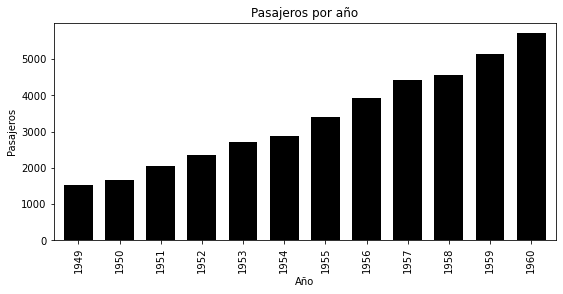

In [98]:
plt.figure()
data = df.groupby("Year")["Passengers"].sum()
data.plot.bar(title = 'Pasajeros por año', color = 'black', width = 0.7, linewidth = 0.5)
plt.xlabel('Año')
plt.ylabel('Pasajeros')
plt.savefig("Images/PasajerosPorAño.png")
plt.show()

Agrupar por años nos permite ver que, efectivamente, conforme pasan los años aumenta la cantidad de pasajeros de avión. Si bien es cierto que se pierde la capacidad de apreciar los ciclos cortos.

> Nota: Al trabajar con series temporales de este tipo (heterocedasticas) es común transformar la variable respuesta con el logaritmo. Esto permite eliminar la heterocedasticidad y facilita la modelización de los datos.

In [100]:
df['Passengers_Log']=np.log(df['Passengers'])

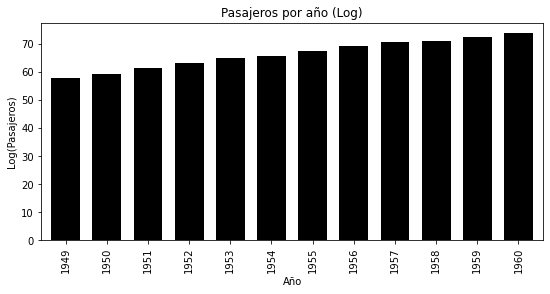

In [101]:
figure = plt.figure()
data = df.groupby("Year")["Passengers_Log"].sum()
data.plot.bar(title = 'Pasajeros por año (Log)', color = 'black', width = 0.7, linewidth = 0.5)
plt.xlabel('Año')
plt.ylabel('Log(Pasajeros)')
plt.savefig("Images/PasajerosPorAño_Log.png")
plt.show()

Vemos que esta sencilla transformación permite obtener una serie mucho más estacionaria que antes.

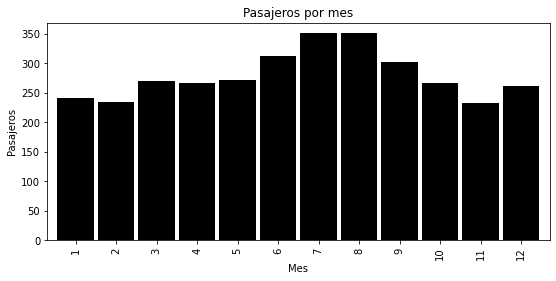

In [102]:
figure = plt.figure()
data = df.groupby("Month")["Passengers"].mean()
data.plot.bar(title = 'Pasajeros por mes', color = 'black', width = 0.9)
plt.xlabel('Mes')
plt.ylabel('Pasajeros')
plt.savefig("Images/PasajerosPorMes.png")
plt.show()

Por último, agrupando los datos por mes se puede ver que existe cierta periodicidad en los viajeros: aumentan en los meses de verano y disminuyen en Febrero y Noviembre. Es importante que pensemos si esto tiene sentido. Lo normal es que la gente viaje cuando tiene vacaciones y el periodo vacacional más usual son los meses de verano, así que parece tener sentido lo que obtenemos.

## Modelos clásicos

Antes de empezar el análisis lo primero que tenemos que hacer es separar la serie en los conjuntos de entrenamiento y test. En el capítulo anterior hacíamos esta separación de manera aleatoria, pero no podemos hacerlo igual al trabajar con series temporales porque no tiene sentido mezclar datos de diferentes momentos temporales. La práctica habitual es utilizar los $N$ primeros datos como conjunto de entrenamiento, los siguientes $M$ como validación y los siguientes $Q$ como test. Por consistencia con lo que haremos más adelante tomaremos 116 valores para el conjunto de entrenamiento, 14 para el de validación y 14 para el de test. En este caso no vamos a utilizar el conjunto de validación para nada, pero si no separamos los datos de la misma forma no podemos realizar una comparativa justa con los modelos neuronales que entrenaremos en el apartado siguiente. También redefinimos el índice de las series como un objeto `pd.DatatimeIndex()`. Esto nos permite especificar la frecuencia de la serie ('MS' significa que cada dato corresponde al inicio de un mes), algo que nos pedirán algunas de las funciones que vamos a utilizar. 

Como es habitual, realizaremos todo el análisis con el conjunto de entrenamiento y solo utilizaremos el de validación y el de test para comprobar los resultados obtenidos.

In [104]:
data_train=df.Passengers_Log[:116]
data_val=df.Passengers_Log[116:130]
data_test=df.Passengers_Log[130:]

data_train.index = pd.DatetimeIndex(data_train.index.values, freq='MS')
data_val.index = pd.DatetimeIndex(data_val.index.values, freq='MS')
data_test.index = pd.DatetimeIndex(data_test.index.values, freq='MS')

El análisis clásico de una serie temporal empieza por estudiar la tendencia y la estacionalidad de la serie. Es posible descomponer la serie utilizando la función `seasonal_decompose()` de la librería `statsmodels`:

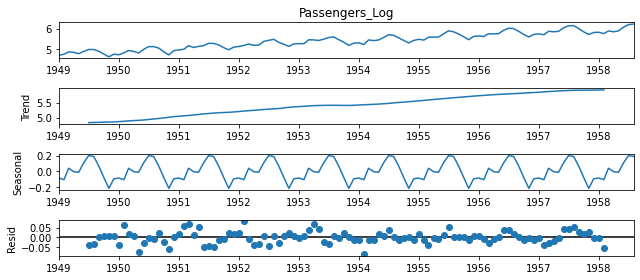

In [105]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data_train, model='additive')
decomposition.plot()
plt.savefig("Images/Decomposition.png")
plt.show()

Representando la descomposición se puede ver que la serie presenta claramente una tendencia creciente y una estacionalidad clara. La estacionalidad, como ya sabíamos, es de 12 meses, que es el tiempo que tarda en repetirse el ciclo de viajeros que hemos visto en la sección de exploración de los datos. Basándonos en estas dos cosas podemos considerar que la serie no es estacionaria.

El primer paso del análisis es determinar la transformación que hace que la serie sea estacionaria. Para ello calculamos la diferencia estacional de la serie, es decir, obtenemos una nueva serie $ts'_{i}=ts_{i+D}-ts_{i}$, dónde $D$ es la estacionalidad (12 meses en nuestro caso).  Esto es muy sencillo de calcular utilizando el método `.diff()`. También hay que utilizar el método `.dropna()` porque al hacer la diferencia perdemos muestras que no queremos mantener como `NaN`s.

In [18]:
pas_log_D = data_train.diff(12).dropna()

Si representamos el resultado parece que hemos quitado prácticamente la estacionalidad. Si siguiésemos viendo mucha estacionalidad podríamos repetir la diferencia, pero no suele ser necesario.

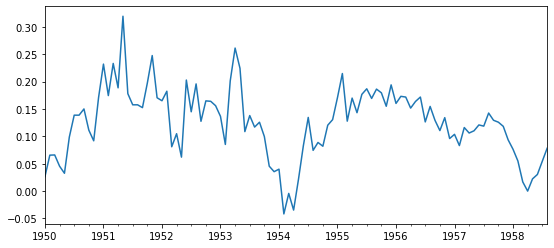

In [106]:
pas_log_D.plot()
plt.savefig("Images/pas_log_D.png")
plt.show()

Para quitar la tendencia vamos a seguir el mismo principio, pero ahora haremos la diferencia respecto al punto siguiente. Aplicaremos la transformación: $ts''_{i} = ts'_{i+1}-ts'_{i}$:

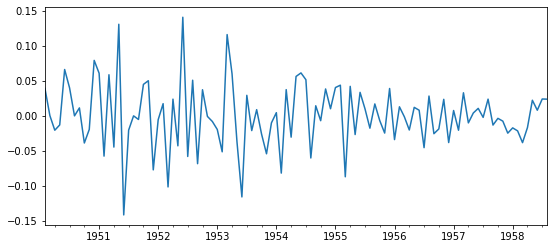

In [107]:
pas_log_D_d = pas_log_D.diff(1).dropna()
pas_log_D_d.plot()
plt.savefig("Images/pas_log_D_d.png")
plt.show()

Tras estas transformaciones vemos que la serie ya no presenta ni estacionalidad ni tendencia. Llegados a este punto es conveniente examinar el correlograma y el correlograma parcial. Para ello podemos utilizar las funciones `plot_acf()` y `plot_pacf()` de `statsmodels` respectivamente. Estas representaciones nos servirán para estimar los parámetros (p,q, P, Q) que tendremos que utilizar en nuestro modelo SARIMA.

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

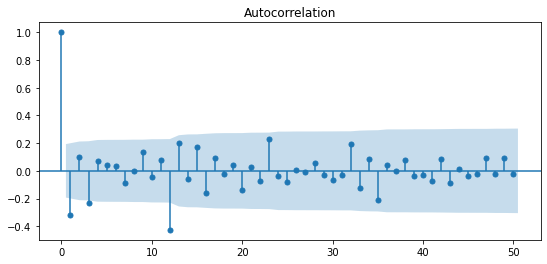

In [108]:
plot_acf(pas_log_D_d, lags=50)
plt.savefig("Images/acf.png")
plt.show()

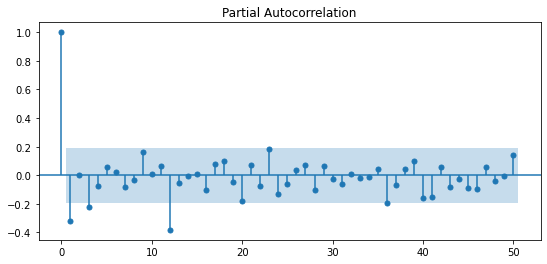

In [109]:
plot_pacf(pas_log_D_d, lags=50, method='ywm')
plt.savefig("Images/pacf.png")
plt.show()

Estas figuras tenemos que analizarlas desde dos escalas distintas: primero nos fijaremos en los primeros retardos, que nos darán los valores de $p$ y $q$, mientras que los retardos estacionales (por ejemplo en 10, 20, etc.) nos servirán para estimar $P$ y $Q$.

Los primeros retardos de las dos figuras se cortan después del primer punto significativo, por lo que podemos asumir que $p=q=1$. Casualmente observamos lo mismo para los retardos estacionales en el ACF, después del primer punto (en 11) no hay ningún punto significativo. Esto quiere decir que tendremos también $Q=1$. En cambio, en la gráfica del PACF se puede entender que se produce un decrecimiento exponencial que lleva asociado $P=0$. Este método depende ciertamente de la interpretación de cada uno pero nos sirve para entender por qué elegimos los parámetros que elegimos. Además, si tenemos dudas entre algunos valores siempre podemos entrenar varios modelos con cada combinación y quedarnos finalmente con el que proporcione mejor métrica. A la hora de elegir un mejor modelo se suele utilizar el AIC (Akaike Information Criterion). 

Después de este análisis podemos plantear un modelo $SARIMA(1,1,1)x(0,1,1)_{12}$ y ver qué resultados obtenemos. Para definir el modelo utilizaremos el objeto `SARIMAX()` de la librería `statsmodels`. Hay que tener en cuenta que tendremos que pasarle la serie sin ninguna de las transformaciones de diferenciación que hemos hecho, porque el modelo las aplicará en función de los valores de $(p,d,q)x(P,D,Q,s)$ que le pasemos. Estas transformaciones solamente las hemos hecho para poder analizar la serie y obtener los parámetros adecuados. Los valores $(p,d,q)$ tenemos que introducirlos en el argumento `order`, y los $(P,D,Q,s)$ en el argumento `seasonal_order`:

In [111]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [112]:
mod = SARIMAX(data_train,
              order=(1,1,1),
              seasonal_order=(0,1,1,12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = mod.fit(maxiter=200, method='powell')
print('AIC:{}'.format(results.aic))

Optimization terminated successfully.
         Current function value: -1.438483
         Iterations: 3
         Function evaluations: 157
AIC:-325.72796810372637


Una vez hemos entrenado el modelo podemos utilizar el método `plot_diagnostics()` del objeto `results` para representar las figuras de diagnóstico que se suelen utilizar. En este caso nos interesa fijarnos principalmente en que los residuos tengan una distribución aleatoria en torno al 0 y en que el Q-Q plot sea lo más parecido posible a una recta. Vemos que se cumplen las dos cosas:

C:\Users\vila_\anaconda3\envs\cuda\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


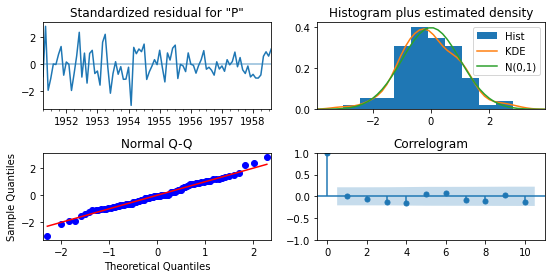

In [114]:
results.plot_diagnostics()
plt.subplots_adjust(hspace=0.5)
plt.savefig("Images/Diagnostic_SARIMA.png")
plt.show()

Cuando trabajamos con series temporales no es suficiente con fijarnos en el valor de una métrica porque se puede dar el caso de que un modelo obtenga un buen valor prediciendo simplemente lo mismo que vio en el instante anterior. Por eso resulta muy útil representar la serie predicha junto a la serie real. Como es algo que vamos a hacer para todos los modelos resulta conveniente definir una función que podamos reutilizar:

In [115]:
def plot_results(Y_train, Y_val, Y_test,
                 pred_train, pred_val, pred_test):
                 
    plt.figure()

    Y_tot = np.concatenate([Y_train, Y_val, Y_test])
    pred_tot = np.concatenate([pred_train, pred_val, pred_test])

    plt.plot(Y_tot, 'k-', label = "True")
    plt.plot(pred_tot, 'k-', label = "Pred", alpha=0.5)

    l = plt.gca()
    ylims = l.get_ylim()
    legend_handles, legend_labels = l.get_legend_handles_labels()

    plt.vlines(len(Y_train), ymin=ylims[0], ymax=ylims[1], linestyle='--', color = 'k')
    plt.vlines(len(Y_train)+len(Y_val), ymin=ylims[0], ymax=ylims[1], linestyle='--', color='k')
    plt.vlines(len(Y_train)+len(Y_val)+len(Y_test), ymin=ylims[0], ymax=ylims[1], linestyle='--', color='k')


    train_bg = plt.fill_betweenx(ylims, x1=0, x2=len(Y_train), color= 'k', alpha=0.1)
    val_bg = plt.fill_betweenx(ylims, x1=len(Y_train), x2=len(Y_train)+len(Y_val), color='k', alpha=0.2)
    test_bg = plt.fill_betweenx(ylims, x1=len(Y_train)+len(Y_val), x2=len(Y_train)+len(Y_val)+len(Y_test), color='k', alpha=0.3)

    legend_handles.extend([train_bg, val_bg, test_bg])
    legend_labels.extend(["Train", "Validation", "Test"])

    plt.legend(legend_handles, legend_labels)
    # plt.show()

Hay que recordar que este modelo ha sido entrenado con los datos transformados con el logaritmo, por lo que para poder estimar correctamente su rendimiento tendremos que deshacer la transformación de las predicciones utilizando la exponencial antes de calcular las métricas o representar los resultados:

C:\Users\vila_\anaconda3\envs\cuda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


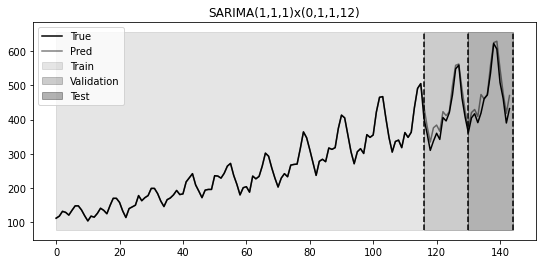

In [116]:
pred_train = results.get_prediction(start=data_train.index.values[0], end=data_train.index.values[-1]).predicted_mean
pred_val = results.get_prediction(start=data_val.index.values[0], end=data_val.index.values[-1]).predicted_mean
pred_test = results.get_prediction(start=data_test.index.values[0], end=data_test.index.values[-1]).predicted_mean

pred_train_o = np.exp(pred_train)
pred_val_o = np.exp(pred_val)
pred_test_o = np.exp(pred_test)

plot_results(np.exp(data_train), np.exp(data_val), np.exp(data_test),
             np.exp(data_train), pred_val_o, pred_test_o)
plt.title("SARIMA(1,1,1)x(0,1,1,12)")
plt.savefig("Images/Pred_SARIMA.png")
plt.show()

Parece que todo el trabajo previo que hemos realizado para estimar los parámetros del modelo *SARIMA* han dado sus frutos, ya que las predicciones parecen ajustarse mucho a los valores reales. Para confirmarlo vamos a calcular el *RMSE* de las predicciones en validación y test:

In [73]:
rmse_val = np.sqrt(mean_squared_error(np.exp(data_val), pred_val_o))
rmse_test = np.sqrt(mean_squared_error(np.exp(data_test), pred_test_o))

print(f"[Validation] RMSE: {rmse_val:.3f} | [Test] RMSE: {rmse_test:.3f}")

[Validation] RMSE: 22.905 | [Test] RMSE: 25.321


Finalmente comprobamos que el modelo ajusta muy bien los datos. Pasamos a estudiar ahora los modelos neuronales.

**Ejercicio: ¿Crees que los modelos neuronales obtendrán mejores o peores resultados? Ten en cuenta la cantidad de datos que tenemos.**

## Modelos Neuronales

### Preparación de los datos

Como ya sabemos, los modelos neuronales funcionan mejor cuando los datos de entrada están en el rango $[0,1]$. La forma más sencilla de transformar los datos para llevarlos a este rango es restar el valor mínimo y dividir por el rango de los datos ($Max - Min$). Hay que tener cuidado al realizar transformaciones en los datos porque si hay que estimar algún parámetro, habrá que hacerlo con el conjunto de entrenamiento y utilizar este valor para transformar los tres conjuntos. Es importante hacerlo de esta manera para asegurarnos de que no se filtra ningún tipo de información de los conjuntos de validación y test al conjunto de entrenamiento.

In [117]:
transf_min = data_train.min()
transf_max = data_train.max()

data_train_scaled = (data_train - transf_min) / (transf_max-transf_min)
data_val_scaled = (data_val - transf_min) / (transf_max-transf_min)
data_test_scaled = (data_test - transf_min) / (transf_max-transf_min)

Podemos observar que esta transformación nos traslada los datos al rango deseado:

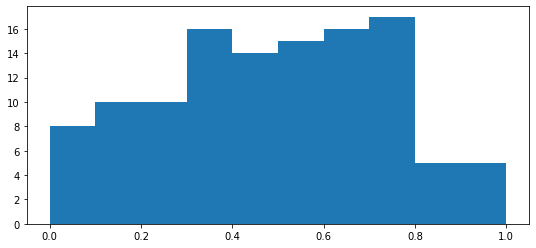

In [119]:
plt.figure()
plt.hist(data_train_scaled)
plt.savefig("Images/Data_Trans.png")
plt.show()

**Ejercicio: Representa también las distribuciones del conjunto de validación y del conjunto de test. ¿Qué observas? ¿Tiene sentido? ¿Funcionará nuestro modelo?**

In [37]:
## SOLUCIÓN ##
# plt.figure()
# plt.subplot(1,3,1)
# plt.title("Train")
# plt.hist(data_train_scaled)
# plt.subplot(1,3,2)
# plt.title("Validation")
# plt.hist(data_val_scaled)
# plt.subplot(1,3,3)
# plt.title("Test")
# plt.hist(data_test_scaled)
# plt.show()

**Ejercicio: Investiga la librería `sklearn` y utiliza `MinMaxScaler` para obtener la misma transformación.**

In [38]:
## SOLUCIÓN ##
# scaler = MinMaxScaler(feature_range=(0,1))
# scaler.fit_transform(df.Passengers_Log)
# data_train_scaled = scaler.transform(data_train)
# data_val_scaled = scaler.transform(data_val)
# data_test_scaled = scaler.transform(data_test)

Hasta ahora hemos estado procesando y visualizando la serie temporal pero hay algo que no hemos visto: las etiquetas. El problema que estamos planteando es un problema supervisado, por lo que está claro que tenemos que proporcionarle unas etiquetas a nuestro modelo para que sea capaz de aprender a modelar la señal. Además, sabemos que queremos predecir los valores futuros a partir de los valores anteriores, por lo que conceptualmente parece estar claro qué va a ser la X y qué va a ser la Y. Toda esta información ya la tenemos disponible pero nos hace falta obtenerla. Tenemos que enventanar nuestra serie temporal.

Para hacerlo vamos a crear una función que tome una serie temporal y nos devuelva pares (*valores anteriores*, *valores futuros*). La cantidad de valores anteriores que consideramos se suele llamar *lag* o retardo, y será un hiperparámetro más de nuestro modelo que tendremos que ajustar. Como tenemos muy pocos datos tomaremos un retardo pequeño de 7, y predeciremos un único valor.

> Nota: Podemos hacer las ventanas superpuestas o no, pero en este ejemplo optamos por hacerlas superpuestas por la poca cantidad de datos que tenemos.

In [39]:
def create_dataset(ts, lag=1, pred_len=1):

	## Creamos dos listas vacías que llenaremos con las ventanas
	X, Y = [], []

	## Creamos un índice con el que recorrer la serie temporal
	## el +1 final es necesario para coger el último elemento
	## porque Python no coge el elemento b al hacer [a:b]
	for i in range(len(ts)-lag-pred_len+1):
		X.append(ts[i:i+lag])
		Y.append(ts[i+lag:i+lag+pred_len])
	return np.array(X), np.array(Y)

**Ejercicio: Rellenar listas utilizando `.append()` es mucho menos eficiente que rellenar un `np.array` de tamaño predefinido. Define una nueva función que haga lo mismo que la anterior pero de forma más eficiente.**

In [40]:
## SOLUCIÓN ##
# def create_dataset(ts, lag=1, pred_len=1):
# 	## Calculamos la cantidad de ventanas que se van a crear.
# 	## el +1 final es necesario para coger el último elemento
# 	## porque Python no coge el elemento b al hacer [a:b]
# 	n_windows = len(ts)-lag-pred_len+1

# 	## Creamos dos arrays vacíos que llenaremos con las ventanas
# 	X = np.empty(shape=(n_windows, lag))
# 	Y = np.empty(shape=(n_windows, pred_len))

# 	for i in range(n_windows):
# 		X[i] = (ts[i:i+lag])
# 		Y[i] = (ts[i+lag:i+lag+pred_len])
# 	return X, Y

Es buena práctica utilizar ejemplos sencillos para comprobar que nuestras funciones se comportan como queremos antes de aplicarlas al conjunto real de datos, sobre todo si nuestros conjuntos son muy grandes. Podemos crear un `np.array` de 15 elementos consecutivos para comprobar que nuestra función devuelve lo que esperamos.

In [41]:
test = np.arange(15)
X, Y = create_dataset(test, lag=7, pred_len=1)
for a, b in zip(X, Y):
    print(f"X: {a} | Y: {b}")

X: [0 1 2 3 4 5 6] | Y: [7]
X: [1 2 3 4 5 6 7] | Y: [8]
X: [2 3 4 5 6 7 8] | Y: [9]
X: [3 4 5 6 7 8 9] | Y: [10]
X: [ 4  5  6  7  8  9 10] | Y: [11]
X: [ 5  6  7  8  9 10 11] | Y: [12]
X: [ 6  7  8  9 10 11 12] | Y: [13]
X: [ 7  8  9 10 11 12 13] | Y: [14]


Ahora que estamos seguros de que obtenemos el resultado deseado, aplicamos esta función a los tres conjuntos de datos que hemos creado con anterioridad para generar los conjuntos finales:

In [120]:
lag = 7
pred_len = 1

X_train, Y_train = create_dataset(data_train_scaled, lag=lag, pred_len=pred_len)
X_val, Y_val = create_dataset(data_val_scaled, lag=lag, pred_len=pred_len)
X_test, Y_test = create_dataset(data_test_scaled, lag=lag, pred_len=pred_len)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((109, 7), (109, 1), (7, 7), (7, 1), (7, 7), (7, 1))

### Generalidades

Todas las capas que vamos a probar esperan que los datos de entrada tengan la forma $(batch, timesteps, feature)$. En nuestro caso vamos a utilizar 7 timesteps (porque miramos 7 instantes temporales, `lag=7`) y 1 feature (porque en cada momento temporal tenemos 1 solo valor, los viajeros). Para ajustar nuestros datos a esto podemos utilizar la función `np.expand_dims(axis=-1)`:

In [121]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((109, 7, 1), (109, 1), (7, 7, 1), (7, 1), (7, 7, 1), (7, 1))

Además, como queremos probar muchos modelos diferentes bajo las mismas condiciones, lo más justo y cómodo es definir una función a la que le pasaremos el modelo y los datos, y entrenará el modelo determinado de la misma forma. Al mantener todo constante menos el modelo podemos atribuirle a este todos los cambios en los resultados. Algo curioso a tener en cuenta es que no es necesario que esta función nos devuelva el modelo porque como es un objeto, se modifica dentro de la función y no hace falta devolverlo. Lo que sí que devolveremos es el histórico del entrenamiento para poder representar las dinámicas de entrenamiento.

Al estar resolviendo un problema de regresión utilizaremos como función de coste el error cuadrático medio o $MSE$ (Mean Squared Error en inglés) y también calcularemos el error absoluto medio o $MAE$ (Mean Absolute Error) en cada época. Como optimizador utilizaremos Adam porque siempre suele dar resultados suficientemente buenos con los valores por defecto.

In [122]:
def train_model(model, 
                X_train, Y_train, 
                X_val, Y_val, 
                epochs=100, verbose=1):
                
    model.compile(loss="mean_squared_error",
                  optimizer="adam",
                  metrics=["mae"])

    history = model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_val, Y_val), verbose=verbose)

    return history


Por el mismo motivo vamos a definir una función que se encargará de evaluar el rendimiento de los modelos. Como el ejercicio se ha planteado como un problema de regresión utilizaremos como métrica el $RMSE$. También hay que tener en cuenta que hemos transformado la variable respuesta por lo que si calculamos el error de la variable transformada podríamos estar infraestimando el error. Lo más correcto es deshacer las transformaciones que hemos hecho y calcular el $RMSE$ de la variable en la escala original.

Para deshacer la transformación de escala que hemos hecho antes tendremos que hacer:

$$
X_{o} = X_{t}(X_{max}-X_{min}) + X_{min}
$$

Y para deshacer el logaritmo tendremos que calcular la exponencial de los resultados. Es conveniente escribir una función que lo implemente para poder aplicarla cómodamente:

In [45]:
def inverse_transform(X, max, min):
    X = X*(max-min)+min
    return np.exp(X)

Es recomendable comprobar que tras aplicar esta función se recupera la distribución original:

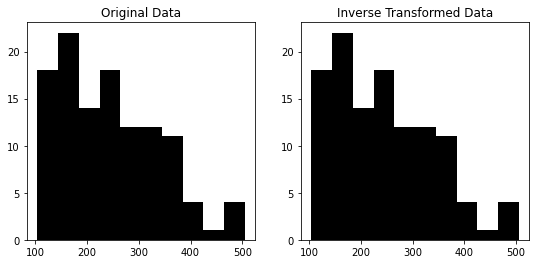

In [123]:
original_data_train = inverse_transform(data_train_scaled, transf_max, transf_min)
plt.figure()
plt.subplot(1,2,1)
plt.title("Original Data")
plt.hist(df.Passengers[:116], color='k')
plt.subplot(1,2,2)
plt.title("Inverse Transformed Data")
plt.hist(original_data_train, color='k')
plt.savefig("Images/Inverse_Transformed.png")
plt.show()

Ahora que ya sabemos que somos capaces de deshacer todas las transformaciones que hemos realizado previamente a los datos podemos definir la función de evaluación de resultados.

In [124]:
def evaluate_model(model, 
                   X_train, Y_train, 
                   X_val, Y_val, 
                   X_test, Y_test, 
                   max, min,
                   verbose=False,
                   plot=False):

    ## Cálculo de las predicciones
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)
    
    ## Invertimos las transformaciones
    pred_train = inverse_transform(pred_train, max, min)
    Y_train_o = inverse_transform(Y_train, max, min)
    pred_val = inverse_transform(pred_val, max, min)
    Y_val_o = inverse_transform(Y_val, max, min)
    pred_test = inverse_transform(pred_test, max, min)
    Y_test_o = inverse_transform(Y_test, max, min)

    ## Cálculo del RMSE
    score_train = np.sqrt(mean_squared_error(Y_train_o, pred_train))
    score_val = np.sqrt(mean_squared_error(Y_val_o, pred_val))
    score_test = np.sqrt(mean_squared_error(Y_test_o, pred_test))
    
    if verbose:
        print(f"[Train] RMSE: {score_train:.2f} | [Validation] RMSE: {score_val:.2f} | [Test] RMSE: {score_test:.2f}")

    if plot:
        plot_results(Y_train_o, Y_val_o, Y_test_o,
                     pred_train, pred_val, pred_test)

    return score_train, score_val, score_test

### Comparativa conjunta

Gracias a todo el trabajo que hemos realizado para definir funciones genéricas estamos en disposición de probar una gran variedad de modelos de forma sencilla y sistemática, algo realmente importante cuando queremos comparar el rendimiento de distintas aproximaciones de correctamente. En general, todo el trabajo que podamos hacer para mejorar nuestra capacidad de iterar sobre una idea nos será de gran ayuda para obtener el mejor resultado posible.

Para ponerlo todo en práctica solamente queda definir los distintos modelos que queremos probar: una RNN simple, un modelo con capa LSTM, otro con capa GRU y finalmente uno en el que implementamos el mecanismo de atención. Los tres primeros modelos son muy sencillos de implementar, ya que *Keras* tiene definidas las capas `layers.SimpleRNN()`, `layers.LSTM()` y `layers.GRU()`, por lo que solamente tendremos que introducirlas en un modelo secuencial sencillo. En cambio, la capa `layers.Attention()` no está pensada para usarse en redes recurrentes, así que no la podemos utilizar. Por suerte para nosotros existe una librería llamada `attention` (instalable con `pip install attention`) que implementa una capa `Attention()` pensada para problemas *muchos a uno*. Esta capa sí que la podemos introducir en un modelo secuencial como el resto. Además de las capas específicas también hay que recordar que estamos resolviendo un problema de regresión, por lo que se suele utilizar una activación lineal en la última capa y el *MSE* como función de coste.

**Ejercicio: Implementa tu propia capa de atención y aplícala al problema. Compara tus resultados.**

In [49]:
# SOLUCIÓN
# class Attention(tf.keras.layers.Layer):
#     def __init__(self):
#         super(Attention, self).__init__()

#     def build(self, input_shape):
        

In [125]:
model_rnn = tf.keras.models.Sequential([
  layers.SimpleRNN(120, input_shape=(lag,1)),
  layers.Dense(16),
  layers.Dense(1)
])
model_lstm = tf.keras.models.Sequential([
    layers.LSTM(16, input_shape = (lag, 1)),
    layers.Dense(16),
    layers.Dense(1)
])
model_gru = tf.keras.models.Sequential([
    layers.GRU(16, input_shape=(lag,1)),
    layers.Dense(16),
    layers.Dense(1)
])
model_attention = tf.keras.models.Sequential([
    layers.LSTM(16, return_sequences=True, input_shape=(lag,1)),
    Attention(),
    layers.Dense(16),
    layers.Dense(1)
])

Una vez hemos definido todos los modelos podemos organizar el experimento de la siguiente manera:

1. Creamos un diccionario con los modelos que queremos probar y un nombre que los pueda identificar.
2. Definimos otro diccionario con las métricas que vamos a guardar de cada modelo.
3. Iteramos respecto al primer diccionario para entrenar los modelos y almacenar los resultados en el segundo diccionario.
4. Transformamos el diccionario de resultados en un `pd.DataFrame` para presentar los resultados que hemos obtenido.

Nótese que esta forma de experimentar con distintos modelos es absolutamente genérica y puede sernos útil para una gran cantidad de problemas diferentes. Esta es una de las virtudes de utilizar funciones genéricas, nos permite reutilizar el código no solo en el problema en cuestión, si no en varios problemas distintos.

> Nota: Inicializamos el diccionario de resultados con los valores que hemos obtenido con *SARIMA* para tener todos los resultados juntos.

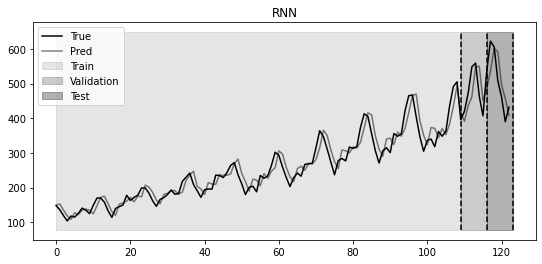

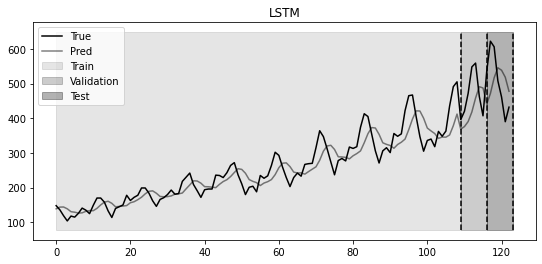

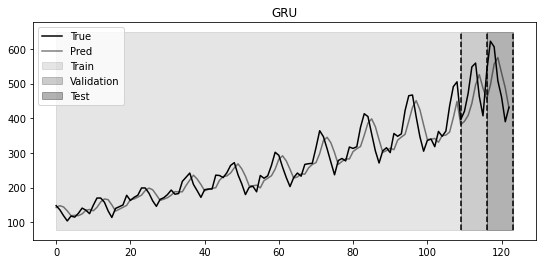

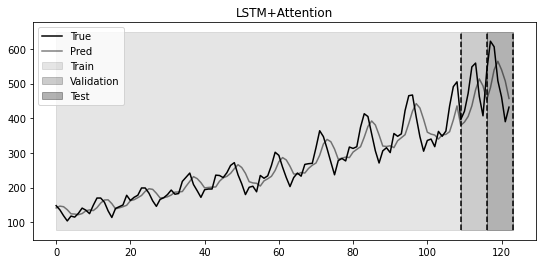

In [126]:
models = {"RNN":model_rnn, "LSTM":model_lstm, "GRU":model_gru, "LSTM+Attention":model_attention}
results = {"Model":["SARIMA"], "Train_RMSE":[np.nan], "Validation_RMSE":[rmse_val], "Test_RMSE":[rmse_test]}

for model_name, model in models.items():
    train_model(model, X_train, Y_train, X_val, Y_val, epochs=100, verbose=0)
    rmse_train, rmse_val, rmse_test = evaluate_model(model, 
                                                     X_train, Y_train, 
                                                     X_val, Y_val, 
                                                     X_test, Y_test, 
                                                     transf_max, transf_min,
                                                     plot=True)
    plt.title(model_name)
    plt.savefig(f"Images/Results_{model_name}.png")
    plt.show()
    
    results["Model"].append(model_name)
    results["Train_RMSE"].append(rmse_train)
    results["Validation_RMSE"].append(rmse_val)
    results["Test_RMSE"].append(rmse_test)

In [75]:
df_results = pd.DataFrame(results).set_index("Model")
df_results

,Train_RMSE,Validation_RMSE,Test_RMSE
Model,,,
SARIMA,NaN,22.905146,25.320911
RNN,24.769366,50.924344,55.547452
LSTM,28.456899,56.161029,67.088460
GRU,25.994434,48.850462,58.595613
LSTM+Attention,26.660537,53.253428,60.622701


A partir de estos resultados vemos que el modelo que obtiene mejores resultados es el más sencillo (*SARIMA*) seguido del que utiliza redes recurrentes sencillas. Esto no nos debería sorprender dada la cantidad de datos de entrenamiento que estamos utilizando. Los modelos más complejos requieren de muchos más datos para aprender que los modelos sencillos, y esto es algo muy importante que tendremos que tener siempre en cuenta. No existe un mejor modelo genérico. No siempre va a ser el modelo más complicado el que nos proporcionará los mejores resultados. Una de las primeras problemáticas que tendremos que resolver en cada problema es adaptarnos a la cantidad de datos con la que vamos a trabajar, por lo que siempre es importante conocer y manejar técnicas más sencillas y técnicas más complejas.